
<img alt='UCL' src="images/ucl_logo.png" align='center'>


[<img src="images/noun_pre_2109128.svg" width="50" align='right'>](050_Models.ipynb)


# 051 A Phenology model 


## Introduction

In the Nothern Hemisphere, and for temperate latitudes, there is a clear seasonal cycle in vegetation, particularly visible in leaf area index (LAI). We have seen that we have access to global LAI data over the last 20-odd years from MODIS. One of the indicators of a changing climate is a change in the pattern of vegetation dynamics. A warmer climate typically means that vegetation appears earlier in the year. 

We call a model that describes the phases of plant development over the year a phenology model. There are many types we could consider, some of the more useful of which are driven by environmental data such as temperature. In that way, we can try to explain how much of the variation we see can be explained by inter-annual temperature variations. A simpler 'descriptive' model that is often used is the "double logistic" curve. 


Mathematically, the function predicts the e.g. LAI (or some vegetation index) as

$$
y = p_0 - p_1\cdot\left[\frac{1}{1+\exp\left(p_2\cdot(t-p_3)\right)} + \frac{1}{1+\exp\left(-p_4\cdot(t-p_5)\right)} - 1\right].
$$

If we inspect this form, we can see that $p_0$ and $p_1$ scale the vertical span of the function, whereas $p_3$ and $p_5$ are some sort of temporal shift, and the remaining parameters $p_2$ and $p_4$ control the slope of the two flanks. 

Let's access some LAI data that we have used before, and also look at the regularised data:

In [1]:
from geog0111.get_lai_data import get_lai_data
from geog0111.regularise import regularise
import numpy as np

# load some data
tile    = ['h17v03','h18v03','h17v04','h18v04']
year    = 2019
fips    = "LU"
    
lai,std,doy =  get_lai_data(year,tile,fips)
std[std<1] = 1
weight = np.zeros_like(std)
mask = (std > 0)
weight[mask] = 1./(std[mask]**2)
weight[lai > 10] = 0.

interpolated_lai = regularise(lai,weight,5.0)

we dont need to process MCD15A3H._h17v03_h18v03_h17v04_h18v04_.2019


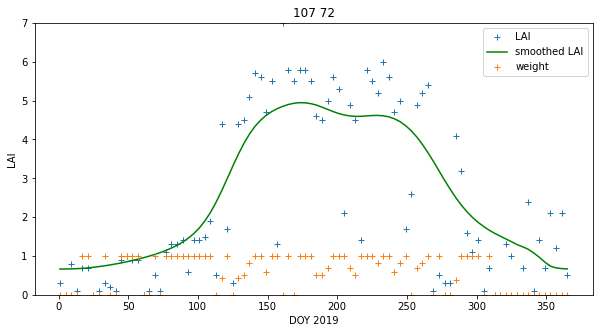

In [2]:
import matplotlib.pyplot as plt

p0,p1 = (107,72)
x_size,y_size=(10,5)

fig, axs = plt.subplots(1,1,figsize=(x_size,y_size))
x = doy
axs.plot(x,lai[:,p0,p1],'+',label='LAI')
axs.plot(x,interpolated_lai[:,p0,p1],'g',label='smoothed LAI')
axs.plot(x,weight[:,p0,p1],'+',label='weight')

axs.set_title(f'{p0} {p1}')
# ensure the same scale for all
axs.set_ylim(0,7)
axs.set_xlabel('DOY 2019')
axs.set_ylabel('LAI')
axs.legend(loc='best')

We can build a function for the model, provide an initial estimate at the model parameters:


In [3]:
import numpy as np

def dbl_sigmoid_function(p, t):
    """The double sigmoid function defined over t (where t is an array).
    Takes a vector of 6 parameters"""

    sigma1 = 1./(1+np.exp(p[2]*(t-p[3])))
    sigma2 = 1./(1+np.exp(-p[4]*(t-p[5])))
    y = p[0] - p[1]*(sigma1 + sigma2 - 1)
    return y

t = np.arange(1, 366)
p = np.array([0.5, 4, 0.07, 100, 0.07, 260])
y = dbl_sigmoid_function(p, t)

and plot the observations and model:

Luxembourg


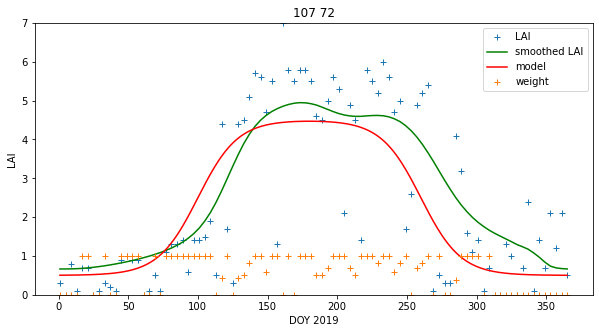

In [4]:
import matplotlib.pyplot as plt

p0,p1 = (107,72)

fig, axs = plt.subplots(1,1,figsize=(x_size,y_size))
x = doy
axs.plot(x,lai[:,p0,p1],'+',label='LAI')
axs.plot(x,interpolated_lai[:,p0,p1],'g',label='smoothed LAI')
axs.plot(t,y,'r',label='model')
axs.plot(x,weight[:,p0,p1],'+',label='weight')

axs.set_title(f'{p0} {p1}')
# ensure the same scale for all
axs.set_ylim(0,7)
axs.set_xlabel('DOY 2019')
axs.set_ylabel('LAI')
axs.legend(loc='best')
print('Luxembourg')

We can see that even with a rough guess of the model parameters, we can produce a plot that is strikingly similar to the regularised result we saw in previous sessions. That result shows what might be interpreted as a double feature around the maximum LAI, but we have seen that spurious features of this sort can arise from the filtering process. We might consider the logistic model a better interpretation of the data then. The double-logistic model has the additional advantage that the parameters have a physical meaning that we can map from year to year and compare. The regularisation result is itself of course, the result of a model. The main difference then is that the regularisation result is from a non-parametric model, and the double-logistic  is a parametric model.

We have seen that there are 6 model parameters. In the previous session, we learned rapid methods of parameter estimation that could only work with low dimensional data. We need to consider how to simply this model then, if we are to apply LUT approaches.

One idea is to attempt to normalise the vertical axis of the model. If we suppose we know the maximum and minimum LAI, we can use these as estimates of $p_0$ and $p_1$. One route to this would be to use the regularised model output. Next, we might assume that the slope parameters $p_2$ and $p_4$ are equal, without too much loss of generalisation. As a further simplification, we might assume we know this parameter, and fix it, at a value of 0.07 say. We can later look at the impact of these assumptions, but they have allowed us to reduce the problem to a 2-D one that we can easily solve with a LUT.

The remaining parameters $p_3$ and $p_5$ the times at which the curve most rapidly increases or decreases. For a LUT, these can be better phrased as:

           width  = p5 - p3
           centre = (p3 + p5)/2
           
so:

           p5 =  centre + width/2
           p3 =  centre - width/2

We might bound the width at between 50 and 250 days, and the centre at by 100 to 300 days. We must take the definition of time as modulo 365 to allow the model to operate in the Southern Hemisphere.

A simplified model and dataset then is:

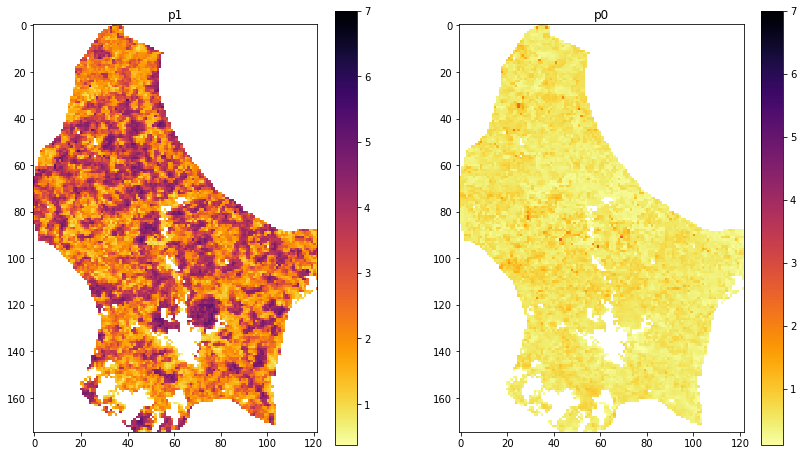

In [5]:
import matplotlib.pyplot as plt

param0 = np.min(interpolated_lai,axis=0)
param1 = np.max(interpolated_lai,axis=0) - param0

fig, axs = plt.subplots(1,2,figsize=(14,8))
axs=axs.flatten()
im = axs[0].imshow(param1,interpolation="nearest",\
                vmax=7,cmap=plt.cm.inferno_r)
axs[0].set_title('p1')
fig.colorbar(im, ax=axs[0])
im = axs[1].imshow(param0,interpolation="nearest",\
                vmax=7,cmap=plt.cm.inferno_r)
axs[1].set_title('p0')
fig.colorbar(im, ax=axs[1])

In [6]:
import numpy as np

'''
Define an interface to the simplified function
which we feed with known values in p
but ones we will wish to solve for in sp
'''
def simple_dbl_sigmoid_function(sp,p, t):
    """The double sigmoid function defined over t (where t is an array).
    p is vector of 6 parameters
    p2 is 2 parameters: width and centre"""
    width,centre = sp
    p[5] =  (centre + width/2)
    p[3] =  (centre - width/2)
    p[2] =  p[4] = 0.07
    return dbl_sigmoid_function(p,t)

# use np.newaxis to resolve shapes of t and parameters
t = np.arange(1, 366)[:,np.newaxis,np.newaxis]
sp = [200.,200.]
p = [param0[np.newaxis,:,:],param1[np.newaxis,:,:],0,0,0,0]
y = simple_dbl_sigmoid_function(sp,p,t)

Luxembourg: Simplified model


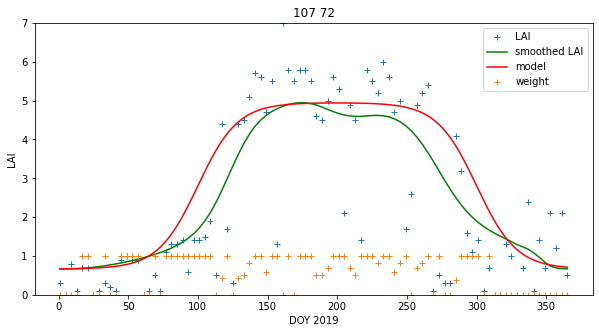

In [7]:
import matplotlib.pyplot as plt

p0,p1 = (107,72)

fig, axs = plt.subplots(1,1,figsize=(x_size,y_size))
x = doy
axs.plot(x,lai[:,p0,p1],'+',label='LAI')
axs.plot(x,interpolated_lai[:,p0,p1],'g',label='smoothed LAI')
axs.plot(t[:,0,0],y[:,p0,p1],'r',label='model')
axs.plot(x,weight[:,p0,p1],'+',label='weight')

axs.set_title(f'{p0} {p1}')
# ensure the same scale for all
axs.set_ylim(0,7)
axs.set_xlabel('DOY 2019')
axs.set_ylabel('LAI')
axs.legend(loc='best')
print('Luxembourg: Simplified model')

As discussed previously, since we are doing pixel-by-pixel processing, we can change the 2D spatial data into a 1D flattened array. 

In [8]:
param0_ = param0.ravel()
param1_ = param1.ravel()
print(f'param1  shape:  {param1.shape}')
print(f'param1_ shape:  {param1_.shape}')

param1  shape:  (175, 122)
param1_ shape:  (21350,)


In [9]:
print(f'lai shape:    {lai.shape}')
print(f'weight shape: {weight.shape}')

lai shape:    (92, 175, 122)
weight shape: (92, 175, 122)


And the same for the observations and weight but using `reshape` following the method in [032_More_numpy](032_More_numpy.ipynb#Simplifying-shape:-flatten,-ravel,-reshape-and-unravel_index):

In [10]:
newshape = (*lai.shape[:1],np.prod(np.array(lai.shape[1:])))
print(newshape)
# reshape 
lai_    = lai.reshape(newshape)
weight_ = weight.reshape(newshape)

print(f'shape of lai  : {lai.shape}')
print(f'shape of lai_ : {lai_.shape}')

(92, 21350)
shape of lai  : (92, 175, 122)
shape of lai_ : (92, 21350)


As with the previous exercise, we need to reconcile the observations and modelling time grid. In this case all we need do is to use `doy` in place of `t`.

We will form axes:

    (time,image index)

In [11]:
sp = [200.,200.]

t = doy[:,np.newaxis]
p = [param0_[np.newaxis,:],param1_[np.newaxis,:],0,0,0,0]
print(f't    shape:  {t.shape}')
print(f'p[1] shape:  {p[1].shape}')

y = simple_dbl_sigmoid_function(sp,p,t)
print(f'y shape:  {y.shape}')

t    shape:  (92, 1)
p[1] shape:  (1, 21350)
y shape:  (92, 21350)


(21350,)


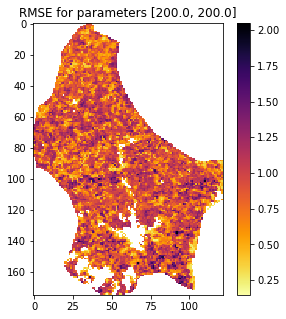

In [12]:
# weighted error
err = (lai_ - y) * weight_
# mean over time
rmse = np.sqrt(np.mean(err*err,axis=0))
print(rmse.shape)


fig, axs = plt.subplots(1,1,figsize=(5,5))
im = axs.imshow(rmse.reshape(lai[0].shape),interpolation="nearest",\
                cmap=plt.cm.inferno_r)
axs.set_title(f'RMSE for parameters {sp}')
fig.colorbar(im, ax=axs)

Let's build a 2-D LUT as previously, and provide a flattened version. We have defined bounds above:

In [13]:
# Use mgrid as previously to define a 2D grid of parameters
sp0min,sp0max,sp0step = 100,250,10
sp1min,sp1max,sp1step = 100,300,10
sp0,sp1 = np.mgrid[sp0min:sp0max+sp0step:sp0step,\
                 sp1min:sp1max+sp1step:sp1step]
sp0_ = sp0.ravel()
sp1_ = sp1.ravel()

print(f'shape of sp0  : {sp0.shape}')
print(f'shape of sp0_ : {sp0_.shape}')

shape of sp0  : (16, 21)
shape of sp0_ : (336,)


We re-process the LAI just to make sure we have it handy and re-shaped:

In [14]:
newshape = (*lai.shape[:1],np.prod(np.array(lai.shape[1:])))
print(newshape)
# reshape 
lai_    = lai.reshape(newshape)
weight_ = weight.reshape(newshape)

print(f'shape of lai  : {lai.shape}')
print(f'shape of lai_ : {lai_.shape}')

(92, 21350)
shape of lai  : (92, 175, 122)
shape of lai_ : (92, 21350)


Assigning the dimensions now is a little more complex, but we can revert to using the original model. We have one dimension that is time, one space, and one parameter space using the flattened arrays:

In [15]:
# dimensions: [t,npix,nsamp]
# more complex for this case
sp0_ext    = sp0_[np.newaxis,np.newaxis,:]
sp1_ext    = sp1_[np.newaxis,np.newaxis,:]
lai_ext    = lai_[:,:,np.newaxis]
weight_ext = weight_[:,:,np.newaxis]
t_ext      = doy[:,np.newaxis,np.newaxis]
param0_ext = param0_[np.newaxis,:,np.newaxis]
param1_ext = param1_[np.newaxis,:,np.newaxis]
param2_ext = 0.07
param3_ext = sp1_ext - sp0_ext/2.
param4_ext = 0.07
param5_ext = sp1_ext + sp0_ext/2.

# print out to check they line up
print(f'sp0_ext:    {sp0_ext.shape}')
print(f'sp1_ext:    {sp1_ext.shape}')
print(f'param0_ext: {param0_ext.shape}')
print(f'param1_ext: {param1_ext.shape}')
print(f'lai_ext:    {lai_ext.shape}')
print(f'weight_ext: {weight_ext.shape}')
print(f't_ext:      {t_ext.shape}')

sp0_ext:    (1, 1, 336)
sp1_ext:    (1, 1, 336)
param0_ext: (1, 21350, 1)
param1_ext: (1, 21350, 1)
lai_ext:    (92, 21350, 1)
weight_ext: (92, 21350, 1)
t_ext:      (92, 1, 1)


In [16]:
sp = [sp0_ext,sp1_ext]
p = [param0_ext,param1_ext,param2_ext,\
     param3_ext,param4_ext,param5_ext]

y = dbl_sigmoid_function(p,t_ext)
print(y.shape)

(92, 21350, 336)


In [17]:
error_ext = (y - lai_ext)*weight_ext
error_ext = error_ext*error_ext
rmse = np.sqrt(np.mean(error_ext,axis=0))
print(rmse.shape)

(21350, 336)


We now have a value of RMSE for each element on the parameter grid (axis 1), for each pixel in the dataset (axis 0). 

We next want to know the minimum over the parameter set (`axis 1`):

(21350,)


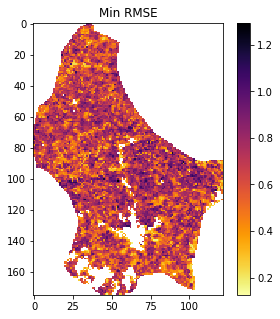

In [18]:
minrmse = rmse.min(axis=1)
print(minrmse.shape)

fig, axs = plt.subplots(1,1,figsize=(5,5))
# reshape for plotting
im = axs.imshow(minrmse.reshape(lai[0].shape),interpolation="nearest",\
                cmap=plt.cm.inferno_r)
axs.set_title(f'Min RMSE')
fig.colorbar(im, ax=axs)

To find the parameters at the minimum value, simply follow the same approach as previously using `argmin`, but with one extra dimension. In this case, `rmse` has shape `(21350, 336)` so we apply the argmin over the parameter dimension (axis 1):

In [19]:
# use np.argmin to find the minimum over axis 1
imin = np.argmin(rmse,axis=1)
p0min,p1min = sp0_[imin],sp1_[imin]
print(f'1D index shape of minimum  : {imin.shape}')
print(f'parameter shape at minimum : {p0min.shape},{p1min.shape}')

width, centre = p0min,p1min
p3 = centre - width/2
p5 = centre + width/2

1D index shape of minimum  : (21350,)
parameter shape at minimum : (21350,),(21350,)


NameError: name 'param0width' is not defined

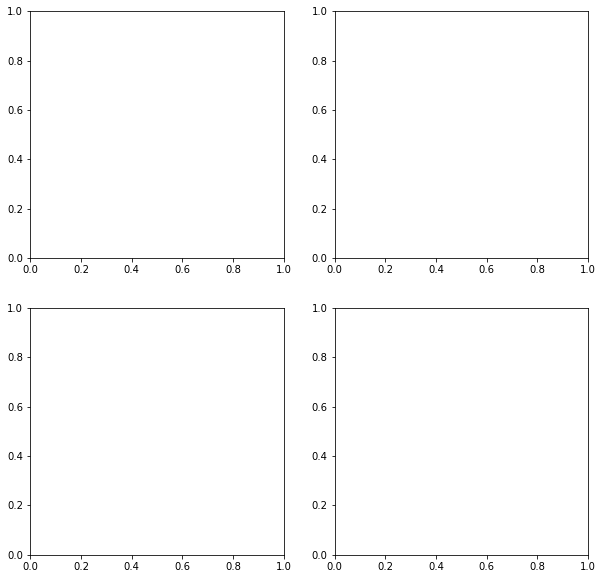

In [20]:
import matplotlib.pyplot as plt

# reshape p0min,p1min before plotting

fig, axs = plt.subplots(2,2,figsize=(10,10))
axs = axs.flatten()
ishape = lai[0].shape

im = axs[0].imshow(param0width,interpolation="nearest",\
                cmap=plt.cm.inferno_r)
axs[0].set_title(f'p0')
fig.colorbar(im, ax=axs[0])

im = axs[1].imshow(param1.reshape(ishape),interpolation="nearest",\
                cmap=plt.cm.inferno_r)
axs[1].set_title(f'p1')
fig.colorbar(im, ax=axs[1])

im = axs[2].imshow(p3.reshape(ishape),interpolation="nearest",\
                cmap=plt.cm.inferno_r)
axs[2].set_title(f'p3')
fig.colorbar(im, ax=axs[2])

im = axs[3].imshow(p5.reshape(ishape),interpolation="nearest",\
                cmap=plt.cm.inferno_r)
axs[3].set_title(f'p5')
fig.colorbar(im, ax=axs[3])

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,2,figsize=(10,5))
axs = axs.flatten()

im = axs[0].imshow(width.reshape(ishape),interpolation="nearest",\
                cmap=plt.cm.inferno_r)
axs[0].set_title(f'width')
fig.colorbar(im, ax=axs[0])

im = axs[1].imshow(centre.reshape(ishape),interpolation="nearest",\
                cmap=plt.cm.inferno_r)
axs[1].set_title(f'centre')
fig.colorbar(im, ax=axs[1])

Now forward model:

In [ ]:
param3_ext = p3[np.newaxis,:,np.newaxis]
param5_ext = p5[np.newaxis,:,np.newaxis]

p = [param0_ext,param1_ext,param2_ext,\
     param3_ext,param4_ext,param5_ext]

# reshape to original lai shape
y = dbl_sigmoid_function(p,t_ext).reshape(lai.shape)

And visualise our test pixel:

In [ ]:
import matplotlib.pyplot as plt

p0,p1 = (107,72)

fig, axs = plt.subplots(1,1,figsize=(x_size,y_size))
x = doy
axs.plot(x,lai[:,p0,p1],'+',label='LAI')
axs.plot(x,interpolated_lai[:,p0,p1],'g',label='smoothed LAI')
axs.plot(doy,y[:,p0,p1],'r',label='model')
axs.plot(x,weight[:,p0,p1],'+',label='weight')

axs.set_title(f'{p0} {p1}')
# ensure the same scale for all
axs.set_ylim(0,7)
axs.set_xlabel('DOY 2019')
axs.set_ylabel('LAI')
axs.legend(loc='best')
print('Luxembourg optimised')

#### Exercise 1

* From the code above, develop a function `solver` in a file `work/lut_solver.py` that takes the following inputs:
    
    * lai, weight : datasets of shape (Nt,Nx,Ny) for observations and reliability
    * 2D parameter grids for model parameters p3 and p5 with shape (Np0,Np1)
    * function slope parameters p2 and p4 for the double sigmoid: float
    * function vertical min and extent parameters p0 and p1 of shape (Nx,Ny)
    
  and solves for the optimal weighted fit between LAI and modelled LAI using the parameters pi
  It should return:
  
    *  p : list of 6 parameter arrays solved for, so 6 of shape (Nx,Ny)
    * RMSE : the RMSE 
    
* The code could be made more efficient by not processing invalid pixels. Develop and use a mask of valid pixels to implement this.

Hint: You might usefully define some utility functions such as `get_lai` and `get_p0p1` to allow you to easily load the datasets you need top run. You might base these around `geog0111.get_lai_data` and `geog0111.regularise`.

In [ ]:
# ANSWER
from geog0111.get_lai_data import get_lai_data
from geog0111.regularise import regularise
from geog0111.lut_solver import lut_solver,get_lai,get_p0p1
import numpy as np

lai,weight,doy = get_lai()
sp0min,sp0max,sp0step = 100,250,10
sp1min,sp1max,sp1step = 100,300,10
sp0,sp1 = np.mgrid[sp0min:sp0max+sp0step:sp0step,\
                 sp1min:sp1max+sp1step:sp1step]
width,centre = sp0,sp1
sp3 = centre - width/2.
sp5 = centre + width/2.
p2 = p4 = 0.07
p0,p1 = get_p0p1(lai,weight)

rmse,p = lut_solver(doy,lai,weight,p0,p1,p2,sp3,p4,sp5)

In [ ]:
# The code could be made more efficient 
# by not processing invalid pixels. 
# Develop and use a mask of valid pixels to implement this.
msg = '''Just apply a mask to the ravelled image data'''
print(msg)

In [ ]:
import matplotlib.pyplot as plt

# reshape p0min,p1min before plotting

fig, axs = plt.subplots(2,3,figsize=(14,10))
axs = axs.flatten()
for i in range(axs.shape[0]):
    im = axs[i].imshow(p[i],interpolation="nearest",\
                    cmap=plt.cm.inferno_r)
    axs[i].set_title(f'p{i}')
    fig.colorbar(im, ax=axs[i])

## Summary

We have shown that, with an initial estimate of 4 of the 6 model parameters, we can use a quite sparse 2-D LUT to provide a mapping of phenolology parameters for a given year for a country the size of Luxembourg in very fast time. The approach could be refined, for instance by other pair-wise inversions to refine the solution, but the improvement in this would likely be quite small. This is evidenced by the low overall RMSE for most of the country (all pixels RMSE less than 1.2 in weighted LAI).

For geospatial model parameter estimation, rapid methods such as this are vital because of the very large dataset dimensions. 

To achieve this LUT-based parameter estimation, we have had to make extensive use of the fast array-processing facilities of `numpy`. As with the previous section, this involved building parameter grids using `np.mgrid`, and careful matching of dataset dimensions with `np.newaxis`. We used `np.argmin` to find the LUT index with the minimum RMSE value, for each pixel in the scene. This was slightly complicated by needing to flatten the LUT dimensions use a 1-D index for the minimum RMSE, and involved use of `np.reshape` and `np.flatten`. 

The programming task here is quite complex, but a very practical one. You will not need to anything quite this complex for formal coursework submission (i.e. to pass the course) but you should all be able to follow and understand the approach taken here, and re-implement it for any similar situation.


[<img src="images/noun_pre_2109128.svg" width="50" align='right'>](050_Models.ipynb)